In [10]:
import os
import sys

from IPython.display import display
from pandas.errors import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

import numpy as np
import pandas as pd
print(pd.__version__)

parent_path = os.path.abspath('..')
sys.path.append(parent_path)
parent_path = os.path.abspath('../../')
sys.path.append(parent_path)
parent_path = os.path.abspath('../../../')
sys.path.append(parent_path)

from core.ShoreNet.conf import get_data_path

DATA_PATH = get_data_path()

# load .env file
project_path = os.path.abspath('../../')
dotenv_path = os.path.join(project_path, 'secret', '.env')

from dotenv import load_dotenv
load_dotenv(dotenv_path)

# load project variables
from core.ShoreNet.definitions.variables import ShoreNetVariablesManager

var = ShoreNetVariablesManager(stage_env)
print(var.data_path)


2.1.4
/mnt/d/data/sisi


# 1 Get standard indicator of trust score



## 1.1 choose some docks (top docks for coal events) as standard dock polygon

as the result, choose:  dock_id = [30, 116, 194, 17, 178]


In [2]:
from core.ShoreNet.events.generic.tools import load_events_with_dock
from core.ShoreNet.events.generic.tools import load_dock_polygon
from core.ShoreNet.events.filter import clean_up_events

# -. load dock polygons
dock_polygon_df = load_dock_polygon(var.engine)
coal_dock_polygon_df = dock_polygon_df[dock_polygon_df['type_id'] == 1]

# -. load events with dock
dock_events_df = load_events_with_dock(year=2023, con=var.engine)
coal_dock_events_df = dock_events_df.loc[dock_events_df['coal_dock_id'].isin(coal_dock_polygon_df['dock_id'])]
coal_dock_events_df = clean_up_events(coal_dock_events_df, var)
# coal_dock_events_df = coal_dock_events_df.apply(lambda row: row if ~row['name'].startswith("dbscan") else None, axis=1)
coal_dock_events_df

original event data shape: (248498, 13)
cleaned event data shape: (179925, 13)


,event_id,mmsi,begin_time,end_time,duration,begin_lng,begin_lat,avg_speed,event_categories,coal_dock_id,year,month,quarter
9,2023010100002883111541336285010,413362850,1672531213,1672733605,202392,108.357,21.5293,0.000000,low_speed_event,1640,2023,1,1
15,2023010100002883111641350417010,413504170,1672531200,1672538718,7518,108.333,21.6203,0.000000,low_speed_event,137,2023,1,1
29,2023010100002885111741235584000,412355840,1672531208,1672548769,17561,108.597,21.7073,0.000000,stop_event_poly,173,2023,1,1
40,2023010100002886109041352038010,413520380,1672531227,1672634081,102854,108.621,19.1011,0.000000,low_speed_event,172,2023,1,1
125,2023010100002910111441246403010,412464030,1672531226,1672539577,8351,111.074,21.4774,0.000000,low_speed_event,184,2023,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940027,2023123121302996129941228258200,412282582,1704058229,1704061434,3205,119.670,39.9274,0.040804,stop_event_poly,10,2023,12,4
2940122,2023123122233003126010090199020,100901990,1704061424,1704066038,4614,120.280,36.0148,0.000000,record_poly,19,2023,12,4
2940188,2023123123043003122041383800310,413838003,1704063866,1704065686,1820,120.360,32.0096,0.473650,low_speed_event,199,2023,12,4
2940190,2023123123063003121941378592510,413785925,1704064007,1704066790,2783,120.336,31.9927,0.642624,low_speed_event,201,2023,12,4


In [5]:
# -. get dock event count, find top 10 docks
top_ten_coal_dock_series = coal_dock_events_df['coal_dock_id'].value_counts().head(50)
top_ten_coal_dock_df = pd.DataFrame(
    {
        'coal_dock_id': top_ten_coal_dock_series.index,
        'count': top_ten_coal_dock_series.values
    }
)
top_ten_coal_dock_df = pd.merge(
    left=top_ten_coal_dock_df,
    right=coal_dock_polygon_df.loc[:, ['dock_id', 'name']],
    left_on='coal_dock_id',
    right_on='dock_id',
    how='left'
)
# top_ten_coal_dock_df.loc[:, ['dock_id', 'name', 'count']]  # choose: [30, 116, 194, 17, 178]
# standard_coal_dock_df = top_ten_coal_dock_df.loc[top_ten_coal_dock_df['dock_id'].isin([30, 116, 194, 17, 178])]
standard_coal_dock_df = top_ten_coal_dock_df.copy()
standard_coal_dock_df

,coal_dock_id,count,dock_id,name
0,1619,15475,1619,天津港
1,1614,13825,1614,舟山港
2,1620,10604,1620,宁波散货集装箱码头
3,30,9757,30,舟山港煤炭1号码头 - 北沦港
4,194,9486,194,苏州太仓武港
5,1624,7285,1624,拓展船坞码头
6,201,6842,201,泰州散货码头(万福港口、罗家桥港口）
7,116,5728,116,曹妃甸散货码头1号
8,129,5246,129,天津港1
9,1630,4697,1630,上海散货4号


## 1.2 calculate some indicator value for each chosen dock

there is no relation between mmsi_nunqie, event_count and avg_duration. each dock has its own distribution of these three values.

In [6]:
# -. calculate some indicator value for each chosen dock
indicator_values = []
for _, row in standard_coal_dock_df.iterrows():
    dock_id = row['dock_id']
    dock_name = row['name']
    for month in range(1, 12+1):
        _month_dock_events = coal_dock_events_df.loc[(coal_dock_events_df['coal_dock_id'] == dock_id) & (coal_dock_events_df['month'] == month)]
        _month_dock_events.loc[:, 'stop_duration'] = _month_dock_events.apply(lambda _row: _row['end_time'] - _row['begin_time'], axis=1).copy()
        _month_dock_events = _month_dock_events.loc[(_month_dock_events['stop_duration'] > 1800) & (_month_dock_events['stop_duration'] < 7 * 24 * 3600)]
        indicator_values.append(
            {
                'dock_id': dock_id,
                'dock_name': dock_name,
                'month': month,
                'mmsi_nunique': _month_dock_events['mmsi'].nunique(),
                'event_count': _month_dock_events.shape[0],
                'avg_duration': _month_dock_events['stop_duration'].mean(),
            }
        )
indicator_values_df = pd.DataFrame(indicator_values)
indicator_values_df

,dock_id,dock_name,month,mmsi_nunique,event_count,avg_duration
0,1619,天津港,1,454,955,72825.646073
1,1619,天津港,2,622,1493,57664.876758
2,1619,天津港,3,650,1406,51951.912518
3,1619,天津港,4,238,530,68739.984906
4,1619,天津港,5,449,958,63757.082463
...,...,...,...,...,...,...
595,199,泰州六助港口（煤炭）,8,35,61,67777.983607
596,199,泰州六助港口（煤炭）,9,48,80,56855.725000
597,199,泰州六助港口（煤炭）,10,31,54,67833.111111
598,199,泰州六助港口（煤炭）,11,30,51,44543.568627


## 1.3 calculate density of effectual area for each dock
1. dbscan events for each dock
2. calculate density of effectual area(cluster_id != -1) for each dock
3. get avg density as trust_score. see how it works.

dbscan parameters:
1. events_count(samples_num) = 80
2. radius = 100m

In [9]:
import numpy as np
from sklearn.cluster import DBSCAN

from core.python.utils.plot import plot_scatter
from core.ShoreNet.analyze.polygon.trust_score import trust_score, effectual_event_percentage
from core.ShoreNet.analyze.departure_arrival_docks import calculate_dd_event_count_month

indicator_values = []
month_dock_events_list = []
for _, row in standard_coal_dock_df.iterrows():
    dock_id = row['dock_id']
    dock_name = row['name']
    for month in range(1, 12+1):
        _month_dock_events = coal_dock_events_df.loc[(coal_dock_events_df['coal_dock_id'] == dock_id) & (coal_dock_events_df['month'] == month)]

        _month_dock_events.loc[:, 'stop_duration'] = _month_dock_events.apply(lambda _row: _row['end_time'] - _row['begin_time'], axis=1)
        _month_dock_events = _month_dock_events.loc[(_month_dock_events['stop_duration'] > 1800) & (_month_dock_events['stop_duration'] < 7 * 24 * 3600)]

        coords = _month_dock_events[[var.column_names.lng_column_name, var.column_names.lat_column_name]].values
        db = DBSCAN(
            eps=0.1 / var.geo_param.kms_per_radian,  # convert 0.1m to radian.
            min_samples=20,
            algorithm='ball_tree',
            metric='haversine'
        ).fit(np.radians(coords))
        _month_dock_events.loc[:, 'cluster_id'] = db.labels_
        # print(f"dock name: {dock_name}, before cluster events shape: {_month_dock_events.shape}")
        before_cluster_events_count = _month_dock_events.shape[0]
        _month_dock_events = _month_dock_events.loc[_month_dock_events['cluster_id'] != -1]
        # print(f"dock name: {dock_name}, after cluster events shape: {_month_dock_events.shape}")
        after_cluster_events_count = _month_dock_events.shape[0]
        if after_cluster_events_count == 0:
            # after dbscan, all events are noise
            continue

        indicator_values.append(
            {
                'dock_id': dock_id,
                'dock_name': dock_name,
                'month': month,
                'before_cluster_count': before_cluster_events_count,
                'after_cluster_count': after_cluster_events_count
            }
        )

        # -. plot scatter
        plot_scatter(
            df=_month_dock_events,
            x_col=var.column_names.lng_column_name,
            y_col=var.column_names.lat_column_name,
            output_file_path=os.path.join(var.data_path, var.dp_names.output_path, 'html', f'dbscan_{dock_name}_{month}.html')
        )

        # -. calculate density of each cluster
        _month_dock_events.to_csv(
            os.path.join(var.data_path, var.dp_names.output_path, 'csv', f'dbscan_{dock_name}_{month}.csv'),
            index=False
        )
        month_dock_events_list.append(_month_dock_events)

        # -. calculate trust score (event_count_per_mmsi)
        _month_dock_trust_score = trust_score(_month_dock_events)
        print(f"dock name: {dock_name}, month: {month}, trust score: {_month_dock_trust_score}")

        # -. calculate departure&arrival ship count
        departure_event_count, arrival_event_count= calculate_dd_event_count_month(
            year=2023,
            month=month,
            dock_id=dock_id,
            con=var.engine
        )
        print(f"dock name: {dock_name}, month: {month}, departure count: {departure_event_count}, arrival count: {arrival_event_count}")

        # -. calculate low_speed / stop_event
        event_category_distribute_percentage = _month_dock_events['event_categories'].value_counts(normalize=True)
        percentage_val = effectual_event_percentage(event_category_distribute_percentage)
        print(f"dock name: {dock_name}, month: {month}, effectual event percentage: {percentage_val}%")

        # -. calculate low_speed / stop_event in dbscan cluster
        for cluster_id, group in _month_dock_events.groupby('cluster_id'):
            event_category_distribute_percentage = group['event_categories'].value_counts(normalize=True)
            percentage_val = effectual_event_percentage(event_category_distribute_percentage)
            print(f"cluster_id: {cluster_id}, effectual event percentage: {percentage_val}%")
        print(f">>>>>>>>>>>>>>>>>>>>>>> {dock_name} >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        break

indicator_values_df = pd.DataFrame(indicator_values)
indicator_values_df

dock name: 天津港, month: 1, trust score: 3.029736342754419
dock name: 天津港, month: 1, departure count: 328, arrival count: 181
dock name: 天津港, month: 1, effectual event percentage: 63.38383838383839%
cluster_id: 0, effectual event percentage: 40.32921810699588%
cluster_id: 1, effectual event percentage: 100.0%
cluster_id: 2, effectual event percentage: 100.0%
>>>>>>>>>>>>>>>>>>>>>>> 天津港 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
dock name: 舟山港, month: 1, trust score: 2.197883597883598
dock name: 舟山港, month: 1, departure count: 171, arrival count: 74
dock name: 舟山港, month: 1, effectual event percentage: 100.0%
cluster_id: 0, effectual event percentage: 100.0%
cluster_id: 1, effectual event percentage: 100.0%
cluster_id: 2, effectual event percentage: 100.0%
>>>>>>>>>>>>>>>>>>>>>>> 舟山港 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
dock name: 宁波散货集装箱码头, month: 1, trust score: 1.768357832643547
dock name: 宁波散货集装箱码头, month: 1, departure count: 141, arrival count: 78
dock name: 宁波散货集装箱码头, month: 1, effectual event pe

,dock_id,dock_name,month,before_cluster_count,after_cluster_count
0,1619,天津港,1,955,396
1,1614,舟山港,1,426,166
2,1620,宁波散货集装箱码头,1,426,210
3,30,舟山港煤炭1号码头 - 北沦港,1,389,277
4,194,苏州太仓武港,1,457,217
5,1624,拓展船坞码头,1,410,391
6,201,泰州散货码头(万福港口、罗家桥港口）,1,192,69
7,116,曹妃甸散货码头1号,1,384,100
8,129,天津港1,1,305,94
9,1630,上海散货4号,1,351,75


In [10]:
# -. calculate density of each cluster
df = month_dock_events_list[0]  # dock_id = 30, month = 1, 宁波北沦港
cluster_gdf = df.groupby('cluster_id')

# np.mean([group.shape[0] for cluster_id, group in cluster_gdf])
for cluster_id, group in cluster_gdf:
    print(f"cluster_id: {cluster_id}, density: {group.shape[0] / group['mmsi'].nunique()}")

    mmsi_events_count_list = [mmsi_group.shape[0] for mmsi, mmsi_group in group.groupby('mmsi')]
    print(f"cluster_id: {cluster_id}, avg density: {np.mean(mmsi_events_count_list)}")

cluster_id: 0, density: 3.1973684210526314
cluster_id: 0, avg density: 3.1973684210526314
cluster_id: 1, density: 3.774193548387097
cluster_id: 1, avg density: 3.774193548387097
cluster_id: 2, density: 2.1176470588235294
cluster_id: 2, avg density: 2.1176470588235294


# 2 Calculate departure:arrival ratio for each dock

results:
- Quarter wise: departure:arrival ratio is in [0.5, 1.5] for most docks. Reasonable.

## 2.1 Month wise

In [4]:
ts_df_month = pd.read_sql(
    sql=f"""
    SELECT
        dock_id, month, departure_count, arrival_count
    FROM
        sisi.{var.table_names.data_features_trust_score_month_table_name}
    """,
    con=var.engine
)

# according to the result, 219 rows data contains NaN value of departure_count or arrival_count.
# total data is 1296, so 9.97% data contains NaN value.
ts_df_month.fillna(0, inplace=True)
ts_df_month.loc[:, 'total_count'] = ts_df_month['departure_count'] + ts_df_month['arrival_count']

ts_df_month = ts_df_month.loc[(ts_df_month['departure_count']!=0) & (ts_df_month['arrival_count']!=0)]
ts_df_month.loc[:, 'ratio'] = ts_df_month['departure_count'] / ts_df_month['arrival_count']
ts_df_month


,dock_id,month,departure_count,arrival_count,total_count,ratio
0,9,1,17.0,2.0,19.0,8.500000
1,9,2,9.0,3.0,12.0,3.000000
2,9,3,11.0,8.0,19.0,1.375000
3,9,4,12.0,13.0,25.0,0.923077
4,9,5,9.0,5.0,14.0,1.800000
...,...,...,...,...,...,...
1291,1640,8,51.0,47.0,98.0,1.085106
1292,1640,9,54.0,56.0,110.0,0.964286
1293,1640,10,35.0,37.0,72.0,0.945946
1294,1640,11,27.0,30.0,57.0,0.900000


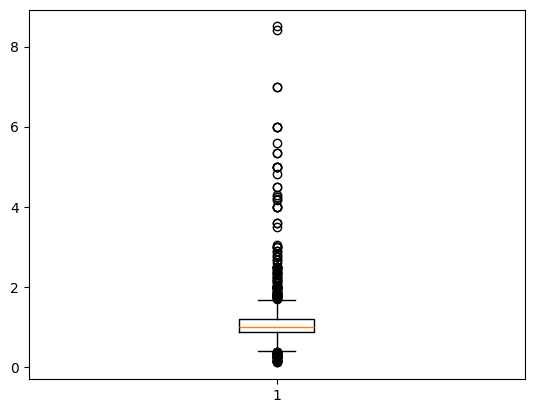

In [16]:
import matplotlib.pyplot as plt

plt.cla()
plt.figure(1)
plt.boxplot(ts_df_month['ratio'])
plt.show()

In [17]:
ts_df_month.loc[ts_df_month['ratio'] > 1.8]

,dock_id,month,departure_count,arrival_count,total_count,ratio
0,9,1,17.0,2.0,19.0,8.500000
1,9,2,9.0,3.0,12.0,3.000000
5,9,6,12.0,6.0,18.0,2.000000
6,9,7,6.0,3.0,9.0,2.000000
12,10,1,42.0,5.0,47.0,8.400000
...,...,...,...,...,...,...
1152,1628,1,64.0,21.0,85.0,3.047619
1153,1628,2,129.0,70.0,199.0,1.842857
1176,1630,1,119.0,41.0,160.0,2.902439
1260,1637,1,47.0,19.0,66.0,2.473684


## 2.2 Quarter wise

In [19]:
ts_df_quarter = pd.read_sql(
    sql=f"""
    SELECT
        dock_id, quarter, departure_count, arrival_count
    FROM
        sisi.{var.table_names.data_features_trust_score_quarter_table_name}
    """,
    con=var.engine
)
ts_df_quarter.fillna(0, inplace=True)
ts_df_quarter= ts_df_quarter.loc[(ts_df_quarter['departure_count']!=0) & (ts_df_quarter['arrival_count']!=0)]
ts_df_quarter.loc[:, 'total_count'] = ts_df_quarter['departure_count'] + ts_df_quarter['arrival_count']
ts_df_quarter.loc[:, 'ratio'] = ts_df_quarter['departure_count'] / ts_df_quarter['arrival_count']
ts_df_quarter

,dock_id,quarter,departure_count,arrival_count,total_count,ratio
0,9,1,37.0,28.0,65.0,1.321429
1,9,2,33.0,27.0,60.0,1.222222
2,9,3,43.0,47.0,90.0,0.914894
3,9,4,24.0,22.0,46.0,1.090909
4,10,1,99.0,92.0,191.0,1.076087
...,...,...,...,...,...,...
427,1638,4,255.0,262.0,517.0,0.973282
428,1640,1,139.0,125.0,264.0,1.112000
429,1640,2,73.0,75.0,148.0,0.973333
430,1640,3,131.0,137.0,268.0,0.956204


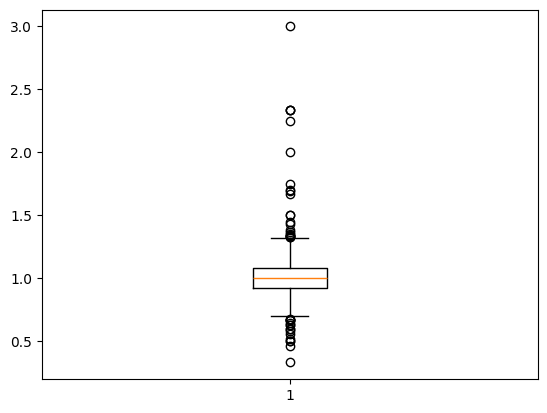

In [20]:
import matplotlib.pyplot as plt

plt.cla()
plt.figure(1)
plt.boxplot(ts_df_quarter['ratio'])
plt.show()

# 3 ship type in each dock

calculate the 70-79 ships count percentage in each dock.

results:
- according to the result, 70-79 ships count percentage is in [0%, 12%] for most docks. Unreasonable, lots of ships may not register right ship type.

In [3]:
from core.ShoreNet.statics.filter import clean_up_statics

# load ships statics data
coal_static_query = f"""
SELECT
    mmsi, ship_name, ship_type, length, width, dwt
FROM
    sisi.{var.table_names.dim_ships_statics_table_name}
"""

statics_df = pd.read_sql(
    sql=coal_static_query, con=var.engine
)
statics_df = clean_up_statics(statics_df)
print(statics_df.shape)

(11935, 7)


In [5]:
coal_dock_events_ship_type_df = pd.merge(
    left=coal_dock_events_df,
    right=statics_df.loc[:, ['mmsi', 'ship_type']],
    on='mmsi',
    how='left'
)
print(coal_dock_events_ship_type_df.loc[coal_dock_events_ship_type_df['ship_type'].notnull()].shape)
coal_dock_events_ship_type_df

(35033, 14)


,event_id,mmsi,begin_time,end_time,duration,begin_lng,begin_lat,avg_speed,event_categories,coal_dock_id,year,month,quarter,ship_type
0,2023010100002883111541336285010,413362850,1672531213,1672733605,202392,108.357,21.5293,0.000000,low_speed_event,1640,2023,1,1,NaN
1,2023010100002883111641350417010,413504170,1672531200,1672538718,7518,108.333,21.6203,0.000000,low_speed_event,137,2023,1,1,NaN
2,2023010100002885111741235584000,412355840,1672531208,1672548769,17561,108.597,21.7073,0.000000,stop_event_poly,173,2023,1,1,70.0
3,2023010100002886109041352038010,413520380,1672531227,1672634081,102854,108.621,19.1011,0.000000,low_speed_event,172,2023,1,1,NaN
4,2023010100002910111441246403010,412464030,1672531226,1672539577,8351,111.074,21.4774,0.000000,low_speed_event,184,2023,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179920,2023123121302996129941228258200,412282582,1704058229,1704061434,3205,119.670,39.9274,0.040804,stop_event_poly,10,2023,12,4,NaN
179921,2023123122233003126010090199020,100901990,1704061424,1704066038,4614,120.280,36.0148,0.000000,record_poly,19,2023,12,4,NaN
179922,2023123123043003122041383800310,413838003,1704063866,1704065686,1820,120.360,32.0096,0.473650,low_speed_event,199,2023,12,4,53.0
179923,2023123123063003121941378592510,413785925,1704064007,1704066790,2783,120.336,31.9927,0.642624,low_speed_event,201,2023,12,4,NaN


In [11]:
ship_type_percentage_docks = []

for dock_id, group in coal_dock_events_ship_type_df.groupby('coal_dock_id'):
    _group = group.loc[group['ship_type'].isin([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])]
    ship_type_percentage_docks.append(
        {
            'dock_id': dock_id,
            'ship_type_70_79_percentage': _group.shape[0] * 100 / group.shape[0]
        }
    )
ship_type_percentage_docks_df = pd.DataFrame(ship_type_percentage_docks)
percentage_12_df = ship_type_percentage_docks_df.loc[ship_type_percentage_docks_df['ship_type_70_79_percentage'] < 12]
percentage_12_others_df = ship_type_percentage_docks_df.loc[ship_type_percentage_docks_df['ship_type_70_79_percentage'] >= 12]
print(percentage_12_df.shape[0] * 100 / ship_type_percentage_docks_df.shape[0], 100 - (percentage_12_df.shape[0] * 100 / ship_type_percentage_docks_df.shape[0]))
print(np.mean(ship_type_percentage_docks_df['ship_type_70_79_percentage']))
ship_type_percentage_docks_df

58.0 42.0
17.02528921795994


,dock_id,ship_type_70_79_percentage
0,9,14.018692
1,10,8.937500
2,11,16.262976
3,12,26.601942
4,13,6.130456
...,...,...
95,1634,27.889714
96,1636,29.328622
97,1637,7.861937
98,1638,10.598291
